In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from scipy.stats import linregress
from scipy.optimize import curve_fit

In [233]:
df  = pd.read_csv('app_events.csv')

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44284 entries, 0 to 44283
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      44284 non-null  int64 
 1   user_id   44284 non-null  object
 2   event     44284 non-null  object
 3   language  44284 non-null  object
dtypes: int64(1), object(3)
memory usage: 865.0+ KB


In [235]:
df.head()

,time,user_id,event,language
0,1625908379,user_sw3kh5lxfre9o3ct,sign_in,es
1,1625916537,user_sw3kh5lxfre9o3ct,message_received,es
2,1625916646,user_sw3kh5lxfre9o3ct,message_received,es
3,1625916689,user_sw3kh5lxfre9o3ct,message_sent,es
4,1625917021,user_sw3kh5lxfre9o3ct,message_received,es


## Clean data

In [236]:
event_value_counts = df.event.value_counts()

In [237]:
## Remove data that has events where that only show up once 
event_list = event_value_counts[event_value_counts > 1].index.tolist()

In [238]:
df = df[df.event.isin(event_list)]

In [240]:
## Convert unix time to datetime and extract date from datetime
df['time'] = pd.to_datetime(df.time, unit='s')
df['date'] = df['time'].astype('M8[D]')

## Calculate and visualize the number of daily active users

In [90]:
df_dau = df[df['event'].str.contains('message')]

In [91]:
# df_dau['date'] = df_dau['time'].astype('M8[D]')

In [92]:
df_dau_date = df_dau.groupby('date').user_id.nunique()

<AxesSubplot:xlabel='date'>

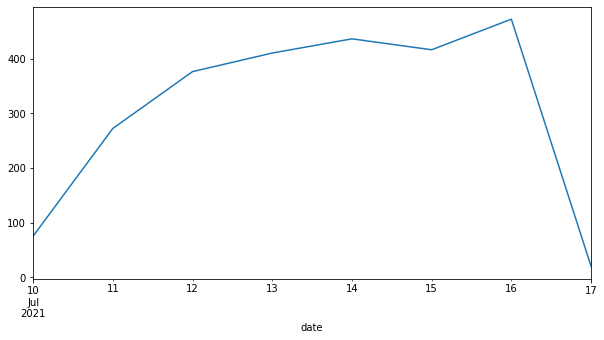

In [264]:
df_dau_date.plot(figsize=(10,5))

In [256]:
df_dau.groupby('date').agg({'time': [np.min, np.max], 'user_id': np.unique})

time                      \
                          amin                amax   
date                                                 
2021-07-10 2021-07-10 02:21:11 2021-07-10 23:59:30   
2021-07-11 2021-07-11 00:00:41 2021-07-11 23:59:27   
2021-07-12 2021-07-12 00:00:01 2021-07-12 23:59:59   
2021-07-13 2021-07-13 00:00:10 2021-07-13 23:58:58   
2021-07-14 2021-07-14 00:00:19 2021-07-14 23:59:43   
2021-07-15 2021-07-15 00:00:43 2021-07-15 23:59:45   
2021-07-16 2021-07-16 00:00:28 2021-07-16 23:59:53   
2021-07-17 2021-07-17 00:00:10 2021-07-17 02:18:55   

                                                      user_id  
                                                       unique  
date                                                           
2021-07-10  [user_03bkhgxmsyjjkq4c, user_0ksgouxviwdltgpx,...  
2021-07-11  [user_03bkhgxmsyjjkq4c, user_08eziztmoj72lyri,...  
2021-07-12  [user_03bkhgxmsyjjkq4c, user_08eziztmoj72lyri,...  
2021-07-13  [user_03bkhgxmsyjjkq4c, user_08eziztmoj72lyri,...  
2021-07-14  [user_03bkhgxmsyjjkq4c, user_08eziztmoj72lyri,...  
2021-07-15  [user_03bkhgxmsyjjkq4c, user_08eziztmoj72lyri,...  
2021-07-16  [user_03bkhgxmsyjjkq4c, user_08eziztmoj72lyri,...  
2021-07-17  [user_03bkhgxmsyjjkq4c, user_1ffhqtentfsgoafl,...

Clearly there is lower amount of daily active users on July 10th and July 17th. This could be due to the data not being collected for the full day especially on July 17th, however, this is not as applicable for July 10th. The plot shows that the daily active users are steadily increasing from July 11th to July 16th.  To show that the difference between July 11th and July 17th are statistically signficant, you can do a hypothesis test of difference between two proportions.

## Calculate and visualize the d1 retention rate.
The d1 retention rate is the number of active users on day 1 divided by the number of users that signed up on day 0.

In [94]:
df.head()

,time,user_id,event,language,date
0,2021-07-10 09:12:59,user_sw3kh5lxfre9o3ct,sign_in,es,2021-07-10
1,2021-07-10 11:28:57,user_sw3kh5lxfre9o3ct,message_received,es,2021-07-10
2,2021-07-10 11:30:46,user_sw3kh5lxfre9o3ct,message_received,es,2021-07-10
3,2021-07-10 11:31:29,user_sw3kh5lxfre9o3ct,message_sent,es,2021-07-10
4,2021-07-10 11:37:01,user_sw3kh5lxfre9o3ct,message_received,es,2021-07-10


In [95]:
df_sign_up = df[df['event'] == 'sign_up']

In [96]:
df_sign_up = df_sign_up.rename(columns={'date':'sign_up_date'})

In [123]:
df_sign_up['active_date'] = df_sign_up['sign_up_date'] + pd.DateOffset(1)

In [124]:
df_sign_up

,time,user_id,event,language,sign_up_date,active_date,active_date
2864,2021-07-10 03:04:37,user_rafuu2ce7hs2pkkx,sign_up,en,2021-07-10,2021-07-11,2021-07-11
5079,2021-07-10 10:24:44,user_vdpwfnh2ypm5jelz,sign_up,en,2021-07-10,2021-07-11,2021-07-11
6148,2021-07-10 10:11:35,user_hxvqospg9o3njzts,sign_up,pt,2021-07-10,2021-07-11,2021-07-11
7755,2021-07-10 03:04:13,user_xmch30hoxdzcsex5,sign_up,zh-Hans,2021-07-10,2021-07-11,2021-07-11
7924,2021-07-10 11:46:27,user_os5rsm1gtih6bkf9,sign_up,en,2021-07-10,2021-07-11,2021-07-11
...,...,...,...,...,...,...,...
44271,2021-07-17 02:18:02,user_hqfsqdlisaczb25g,sign_up,en,2021-07-17,2021-07-18,2021-07-18
44273,2021-07-17 02:16:52,user_7dkydkqphhkqzak3,sign_up,es,2021-07-17,2021-07-18,2021-07-18
44275,2021-07-17 02:17:51,user_srqqbf48papxju3g,sign_up,en,2021-07-17,2021-07-18,2021-07-18
44277,2021-07-17 02:18:54,user_s5z4e8jwtpsojciw,sign_up,en,2021-07-17,2021-07-18,2021-07-18


In [258]:
df_messages = df[df.event.str.contains('message')]
df_messages.rename(columns={'date': 'active_date'}, inplace=True)
df_messages.head()

c:\Users\sanoo\data_eng_projects\spotify_recommendations\venv\lib\site-packages\pandas\core\frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,time,user_id,event,language,active_date
1,2021-07-10 11:28:57,user_sw3kh5lxfre9o3ct,message_received,es,2021-07-10
2,2021-07-10 11:30:46,user_sw3kh5lxfre9o3ct,message_received,es,2021-07-10
3,2021-07-10 11:31:29,user_sw3kh5lxfre9o3ct,message_sent,es,2021-07-10
4,2021-07-10 11:37:01,user_sw3kh5lxfre9o3ct,message_received,es,2021-07-10
5,2021-07-10 11:39:28,user_sw3kh5lxfre9o3ct,message_received,es,2021-07-10


In [204]:
d1_retention = df_sign_up.merge(df_messages, on=['user_id','active_date'], how='left')#, suffixes=('_l', '_r'))

In [205]:
d1_retention.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3788 entries, 0 to 3787
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time_x        3788 non-null   datetime64[ns]
 1   user_id       3788 non-null   object        
 2   event_x       3788 non-null   object        
 3   language_x    3788 non-null   object        
 4   sign_up_date  3788 non-null   datetime64[ns]
 5   active_date   3788 non-null   datetime64[ns]
 6   active_date   3788 non-null   datetime64[ns]
 7   time_y        1180 non-null   datetime64[ns]
 8   event_y       1180 non-null   object        
 9   language_y    1180 non-null   object        
dtypes: datetime64[ns](5), object(5)
memory usage: 251.5+ KB


In [206]:
d1_retention = d1_retention.groupby('sign_up_date').count()

In [207]:
d1_retention = d1_retention.time_y/d1_retention.time_x

<AxesSubplot:xlabel='sign_up_date'>

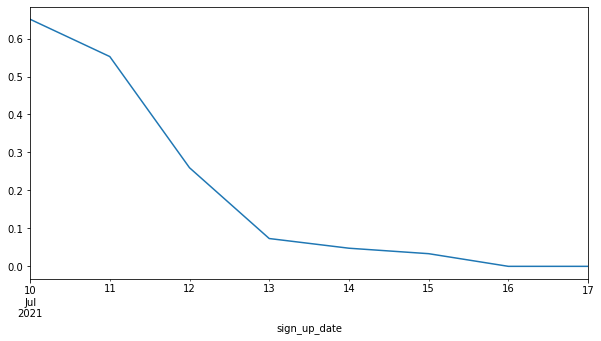

In [263]:
d1_retention.plot(figsize=(10,5))

The d1 retention rate is decreasing over the 7 day period. We need to see if the d1 retention rate is a truly a indicator of how well the app is doing. We should calculate and predict how the d2, d3 and so on so forth retention rate is.

## Predict d1 retnetion rate to day 14.

In [210]:
d14_regression = d1_retention.to_frame()
d14_regression['rn'] = np.arange(len(d14_regression))+1

In [211]:
d14_regression = d14_regression.rename(columns={0: 'd1_retention'}).reset_index()

In [270]:
res = linregress(d14_regression.rn, d14_regression.d1_retention)
res

LinregressResult(slope=-0.09550739558144691, intercept=0.6319455163794412, rvalue=-0.8952372066092765, pvalue=0.0026533700758174486, stderr=0.019407007580854507, intercept_stderr=0.09800058445083519)

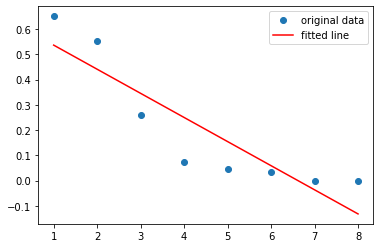

In [213]:
plt.plot(d14_regression.rn, d14_regression.d1_retention, 'o', label='original data')
plt.plot(d14_regression.rn, res.intercept + res.slope*d14_regression.rn, 'r', label='fitted line')
plt.legend()
plt.show()

In [266]:
print('Predicting D1 retention rate to day 14 with Linear Regression: ', "{:.3f}".format(res.slope*14 + res.intercept))

Predicting D1 retention rate to day 14 with Linear Regression:  -0.705


Using linear regression is not possible since the d1 retention rate cannot be less than zero.  The d1 retention rate is decreasing and approaching 0, so the data is more exponential than linear. Switching to use exponential regression instead of linear regression to predict the d14 retention rate.

In [224]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [219]:
popt, pcov = curve_fit(func, d14_regression.rn, d14_regression.d1_retention)

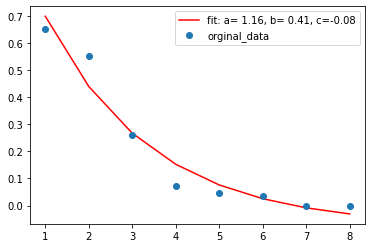

In [231]:
plt.plot(d14_regression.rn, func(d14_regression.rn, *popt), 'r-', label='fit: a=%5.2f, b=%5.2f, c=%5.2f' % tuple(popt))
plt.plot(d14_regression.rn, d14_regression.d1_retention, 'o', label='orginal_data')
plt.legend()
plt.show()

In [265]:
print('Predicting D1 retention rate to day 14 with Exponential Regression: ', "{:.3f}".format(func(14, *popt)))

Predicting D1 retention rate to day 14 with Exponential Regression:  -0.072
